In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os
import argparse
import math
import scipy

from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt

import cx_rate
import trials
import plotter


from cx_spiking.constants import *

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.network_creation as nc

import cx_spiking.optimisation.metric as metric
import cx_spiking.optimisation.ng_optimiser as ng_optimiser

import itertools
import multiprocessing

In [2]:
######################################
### INPUTS
######################################
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)


Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz
/Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz exists - not overwriting it


In [3]:
######################################
### RATE BASED CX
######################################
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=0,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))


In [40]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')

f_stimulus = TimedArray(flow*Hz, dt=1.*time_step*ms)
P_FLOW = PoissonGroup(N_TN2, rates='f_stimulus(t,i)')

#global CPU4_memory_stimulus
CPU_MEMORY_starting_value = 50 #Hz
CPU4_memory_stimulus = CPU_MEMORY_starting_value*np.ones((T_outbound,N_CPU4)) * Hz
P_CPU4_MEMORY = PoissonGroup(N_CPU4, rates=CPU4_memory_stimulus[0,:], name='P_CPU4_MEMORY')

In [41]:
# Neuron groups already optimised
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, TL2_neuron_params, name='TL2')
G_CL1 = nc.generate_neuron_groups(N_CL1, eqs, threshold_eqs, reset_eqs, CL1_neuron_params, name='CL1')
G_TB1 = nc.generate_neuron_groups(N_TB1, eqs, threshold_eqs, reset_eqs, TB1_neuron_params, name='TB1')
G_TN2 = nc.generate_neuron_groups(N_TN2, eqs, threshold_eqs, reset_eqs, TN2_neuron_params, name='TN2')
G_CPU4 = nc.generate_neuron_groups(N_CPU4, eqs, threshold_eqs, reset_eqs, CPU4_neuron_params, name='CPU4')

print(f'TL2_neuron_params {TL2_neuron_params}')
print(f'CL1_neuron_params {CL1_neuron_params}')
print(f'TB1_neuron_params {TB1_neuron_params}')
print(f'TN2_neuron_params {TN2_neuron_params}')
print(f'CPU4_neuron_params {CPU4_neuron_params}')

TL2_neuron_params {'spike_count': [0], 'EL': [-52. * mvolt], 'Vm': [-52. * mvolt], 'EE': [0. * volt], 'EI': [-80. * mvolt], 'gL': [1. * usiemens], 'gE': '(randn() * 1.5 + 4) * 10.*nS', 'gI': '(randn() * 12 + 20) * 10.*nS', 'tauE': [0.5 * msecond], 'tauI': [2. * msecond]}
CL1_neuron_params {'spike_count': [0], 'EL': [-52. * mvolt], 'Vm': [-52. * mvolt], 'EE': [0. * volt], 'EI': [-80. * mvolt], 'gL': [1. * usiemens], 'gE': '(randn() * 1.5 + 4) * 10.*nS', 'gI': '(randn() * 12 + 20) * 10.*nS', 'tauE': [1.5 * msecond], 'tauI': [2. * msecond]}
TB1_neuron_params {'spike_count': [0], 'EL': [-52. * mvolt], 'Vm': [-52. * mvolt], 'EE': [0. * volt], 'EI': [-80. * mvolt], 'gL': [1. * usiemens], 'gE': '(randn() * 1.5 + 4) * 10.*nS', 'gI': '(randn() * 12 + 20) * 10.*nS', 'tauE': [0.5 * msecond], 'tauI': [1. * msecond]}
TN2_neuron_params {'spike_count': [0], 'EL': [-52. * mvolt], 'Vm': [-52. * mvolt], 'EE': [0. * volt], 'EI': [-80. * mvolt], 'gL': [1. * usiemens], 'gE': '(randn() * 1.5 + 4) * 10.*nS',

In [42]:
# Neuron groups to optimise
G_CPU1A = nc.generate_neuron_groups(N_CPU1A, eqs, threshold_eqs, reset_eqs, neuron_params, name='CPU1A')
G_CPU1B = nc.generate_neuron_groups(N_CPU1B, eqs, threshold_eqs, reset_eqs, neuron_params, name='CPU1B')
G_PONTINE = nc.generate_neuron_groups(N_PONTINE, eqs, threshold_eqs, reset_eqs, neuron_params, name='PONTINE')
G_MOTOR = nc.generate_neuron_groups(N_MOTOR, eqs, threshold_eqs, reset_eqs, neuron_params, name='MOTOR')


# Synapses optimised
# Inputs
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, params=H_TL2_synapses_params, on_pre=synapses_eqs_ex, name='S_P_HEADING_TL2')
S_P_FLOW_TN2 = nc.connect_synapses(P_FLOW, G_TN2, W_FLOW_TN2, model=synapses_model, params=F_TN2_synapses_params, on_pre=synapses_eqs_ex, name='S_P_FLOW_TN2')

# TL2
S_TL2_CL1 = nc.connect_synapses(G_TL2, G_CL1, W_TL2_CL1, model=synapses_model, params=TL2_CL1_synapses_params, on_pre=synapses_eqs_ex, name='S_TL2_CL1')

# CL1
S_CL1_TB1 = nc.connect_synapses(G_CL1, G_TB1, W_CL1_TB1, model=synapses_model, params=CL1_TB1_synapses_params, on_pre=synapses_eqs_ex, name='S_CL1_TB1')

# TN2
S_TN2_CPU4 = nc.connect_synapses(G_TN2, G_CPU4, W_TN2_CPU4, model=synapses_model, params=TN2_CPU4_synapses_params, on_pre=synapses_eqs_ex, name='S_TN2_CPU4')

# TB1
S_TB1_TB1 = nc.connect_synapses(G_TB1, G_TB1, W_TB1_TB1, model=synapses_model, params=TB1_TB1_synapses_params, on_pre=synapses_eqs_in, name='S_TB1_TB1')
S_TB1_CPU4 = nc.connect_synapses(G_TB1, G_CPU4, W_TB1_CPU4, model=synapses_model, params=TB1_CPU4_synapses_params, on_pre=synapses_eqs_in, name='S_TB1_CPU4')



print(f'H_TL2_synapses_params {H_TL2_synapses_params}')
print(f'F_TN2_synapses_params {F_TN2_synapses_params}')
print(f'TL2_CL1_synapses_params {TL2_CL1_synapses_params}')
print(f'CL1_TB1_synapses_params {CL1_TB1_synapses_params}')
print(f'TN2_CPU4_synapses_params {TN2_CPU4_synapses_params}')
print(f'TB1_TB1_synapses_params {TB1_TB1_synapses_params}')
print(f'TB1_CPU4_synapses_params {TB1_CPU4_synapses_params}')

H_TL2_synapses_params {'wE': [0.9 * usiemens], 'wI': [200. * nsiemens]}
F_TN2_synapses_params {'wE': [0.75 * usiemens], 'wI': [200. * nsiemens]}
TL2_CL1_synapses_params {'wE': [0.45 * usiemens], 'wI': [200. * nsiemens]}
CL1_TB1_synapses_params {'wE': [0.8 * usiemens], 'wI': [200. * nsiemens]}
TN2_CPU4_synapses_params {'wE': [0.5 * usiemens], 'wI': [0.6 * usiemens]}
TB1_TB1_synapses_params {'wE': [0.7 * usiemens], 'wI': [0.7 * usiemens]}
TB1_CPU4_synapses_params {'wE': [0.5 * usiemens], 'wI': [0.6 * usiemens]}


In [43]:
# Synapses to optimise
# TB1
S_TB1_CPU1A = nc.connect_synapses(G_TB1, G_CPU1A, W_TB1_CPU1A, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_in, name='S_TB1_CPU1A')
S_TB1_CPU1B = nc.connect_synapses(G_TB1, G_CPU1B, W_TB1_CPU1B, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_in, name='S_TB1_CPU1B')

# CPU4 accumulator
S_CPU4_M_PONTINE = nc.connect_synapses(P_CPU4_MEMORY, G_PONTINE, W_CPU4_PONTINE, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_ex, name='S_CPU4_M_PONTINE')
S_CPU4_M_CPU1A = nc.connect_synapses(P_CPU4_MEMORY, G_CPU1A, W_CPU4_CPU1A, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_ex, name='S_CPU4_M_CPU1A')
S_CPU4_M_CPU1B = nc.connect_synapses(P_CPU4_MEMORY, G_CPU1B, W_CPU4_CPU1B, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_ex, name='S_CPU4_M_CPU1B')

# Pontine
S_PONTINE_CPU1A = nc.connect_synapses(G_PONTINE, G_CPU1A, W_PONTINE_CPU1A, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_in, name='S_PONTINE_CPU1A')
S_PONTINE_CPU1B = nc.connect_synapses(G_PONTINE, G_CPU1B, W_PONTINE_CPU1B, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_in, name='S_PONTINE_CPU1B')

# CPU1A
S_CPU1A_MOTOR = nc.connect_synapses(G_CPU1A, G_MOTOR, W_CPU1A_MOTOR, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_ex, name='S_CPU1A_MOTOR')

# CPU1B
S_CPU1B_MOTOR = nc.connect_synapses(G_CPU1B, G_MOTOR, W_CPU1B_MOTOR, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_ex, name='S_CPU1B_MOTOR')

In [44]:
motors = cx_spiking.inputs.compute_motors(cx_log.cpu1)
MOTOR_stimulus = TimedArray(50*motors.T*Hz, dt=1.*time_step*ms)
P_MOTOR = PoissonGroup(N_MOTOR, rates='MOTOR_stimulus(t,i)')
SPM_MOTOR_TARGET = SpikeMonitor(P_MOTOR)
SPM_MOTOR = SpikeMonitor(G_MOTOR)

In [45]:
global CPU4_memory, CPU4_memory_history, CPU4_memory_stimulus
CPU4_memory_history = CPU_MEMORY_starting_value * np.ones((T_outbound, N_CPU4))
CPU4_memory = CPU_MEMORY_starting_value * np.ones(N_CPU4)


def get_agent_timestep(t, sim_time_step):
    return int((t/ms + 0.5) / sim_time_step)


def extract_spike_counts(SPM, t, time_step):
    '''
    Count spikes for each neuron in the [t-time_step, t] interval
    of the simulation
    '''
    spike_trains = SPM.spike_trains()
    neurons = np.zeros(len(SPM.spike_trains()), dtype=int)
    for idx in range(len(spike_trains)):
        spike_train = spike_trains[idx]
        neurons[idx] = len(spike_train[(spike_train > t-time_step*ms) & (spike_train < t)])
    return neurons


@network_operation(dt=time_step*ms, when='start', order=2, name='CPU4_accumulator')
def CPU4_accumulator(t):
    global CPU4_memory, CPU4_memory_history, CPU4_memory_stimulus
    
    timestep = get_agent_timestep(t, time_step)
    
    if t < time_step*ms:
        return

    #print(timestep, CPU4_memory)#, CPU4_memory_history[timestep,:], CPU4_memory_stimulus[timestep,:])
    neurons_responses = G_CPU4.spike_count

    mem_update = neurons_responses 
    CPU4_memory = CPU4_memory_history[timestep-1,:]
    CPU4_memory += mem_update * 0.05
    CPU4_memory -= 0.025 * (1./(mem_update+0.1))
    CPU4_memory = np.clip(CPU4_memory, 0, np.inf)
    #print(CPU4_memory_history[timestep,:])
    CPU4_memory_history[timestep,:] = CPU4_memory
    #print(CPU4_memory_history[timestep,:])

    CPU4_memory_stimulus[timestep,:] = CPU4_memory * Hz
    
    G_CPU4.spike_count = 0


@network_operation(dt=time_step*ms, when='start', order=4, name='set_rates')
def set_rates(t):
    global CPU4_memory_stimulus
    timestep = get_agent_timestep(t, time_step)

    if t < time_step*ms:
        return
    P_CPU4_MEMORY.rates = CPU4_memory_stimulus[timestep,:]

In [46]:
net = Network(collect())

net.store('initialised')

In [47]:
#net.restore('initialised')
#net.run(100*20*ms, report='text')

In [48]:
def run_simulation_NET(net, cx_log, tauE_, wE_, tauI_, wI_, 
                           Group, Target,
                           G_CPU1A, G_CPU1B, G_PONTINE, G_MOTOR,
                           S_TB1_CPU1A,                  
                           S_CPU4_M_PONTINE,
                           S_CPU4_M_CPU1A,
                           S_PONTINE_CPU1A, 
                           S_TB1_CPU1B,
                           S_CPU4_M_CPU1B, 
                           S_PONTINE_CPU1B, 
                           S_CPU1A_MOTOR, 
                           S_CPU1B_MOTOR,  
                           time, dt_, delta, rate_correction): 

    net.restore('initialised') 
    global CPU4_memory, CPU4_memory_history, CPU4_memory_stimulus


    # set the parameters 
    Group.set_states({'tauE' : tauE_*ms, 'tauI' : tauI_*ms})
    print(f'taueE: {tauE_} - tauI {tauI_}')
    G_CPU1A.set_states({'tauE' : tauE_*ms, 'tauI' : tauI_*ms})
    G_CPU1B.set_states({'tauE' : tauE_*ms, 'tauI' : tauI_*ms})
    G_PONTINE.set_states({'tauE' : tauE_*ms, 'tauI' : tauI_*ms})
    #G_MOTOR.set_states({'tauE' : tauE_*ms, 'tauI' : tauI_*ms})

    S_TB1_CPU1A.set_states({'wE' : wE_*nS, 'wI' : wI_*nS})
    S_TB1_CPU1B.set_states({'wE' : wE_*nS, 'wI' : wI_*nS})
    S_CPU4_M_PONTINE.set_states({'wE' : wE_*nS, 'wI' : wI_*nS})
    S_CPU4_M_CPU1A.set_states({'wE' : wE_*nS, 'wI' : wI_*nS})
    S_CPU4_M_CPU1B.set_states({'wE' : wE_*nS, 'wI' : wI_*nS})
    S_PONTINE_CPU1A.set_states({'wE' : wE_*nS, 'wI' : wI_*nS})
    S_PONTINE_CPU1B.set_states({'wE' : wE_*nS, 'wI' : wI_*nS})
    S_CPU1A_MOTOR.set_states({'wE' : wE_*nS, 'wI' : wI_*nS})
    S_CPU1B_MOTOR.set_states({'wE' : wE_*nS, 'wI' : wI_*nS})

    print(f'wE: {wE_} - wI {wI_}')

    model_spike_monitor_motor = SpikeMonitor(Group, name='MOTOR_source_spike_monitor')
    target_spike_monitor_motor = SpikeMonitor(Target, name='MOTOR_target_spike_monitor')
    
    net.add(model_spike_monitor_motor, target_spike_monitor_motor)
    net.run(time, report='text')
    
    if np.sum(model_spike_monitor_motor.count) == 0 or np.sum(target_spike_monitor_motor.count) == 0:
        print('model count = ', model_spike_monitor_motor.count)
        print('target count = ', target_spike_monitor_motor.count)
        gf_motor = 10000
    else:
        gf_motor = metric.compute_gamma_factor(model_spike_monitor_motor, target_spike_monitor_motor, time, 
                                        dt_=dt_, delta=delta, rate_correction=rate_correction)

    motors_rate_model = cx_spiking.inputs.compute_motors(cx_log.cpu1)
    rotations_rate_model = np.sign(motors_rate_model[0,:1500]-motors_rate_model[1,:1500])

    MOTOR_spikes =  cx_spiking.inputs.get_spikes_rates(target_spike_monitor_motor, 2, 1500, 20)
    rotations_spike_model = np.sign((MOTOR_spikes[0,:1500]-MOTOR_spikes[1,:1500]))
    
    measure = np.sum(np.abs(rotations_rate_model-rotations_spike_model))

    net.remove(model_spike_monitor_motor, target_spike_monitor_motor)
    print(f'Gamma factor: {gf_motor} - {measure}')

    gf = gf_motor
    return gf

In [49]:
tauE_s_full = [0.5, 1, 1.5, 2, 2.5] # ms
wE_s_full = [300, 400, 500, 600, 700, 800] # nS
tauI_s_full = [0.5, 1, 1.5, 2, 2.5] # ms
wI_s_full = [400, 500, 600, 700, 800, 900] # nS


gamma_factors = np.zeros((len(tauE_s_full), len(wE_s_full), len(tauI_s_full), len(wI_s_full)))

delta = 1*ms
rate_correction = True


tauE_ = tauE_s_full[3]
for we_, wE_ in enumerate(wE_s_full):
    for ti_, tauI_ in enumerate(tauI_s_full):
        for wi_, wI_ in enumerate(wI_s_full):
            gamma_factors[3, we_, ti_, wi_] = run_simulation_NET(net, cx_log,
                                                                          tauE_, 700, 3, 700, 
                                                                          G_MOTOR, P_MOTOR,
                                                                          G_CPU1A, G_CPU1B, G_PONTINE, G_MOTOR, 
                                                                          S_TB1_CPU1A,                  
                                                                          S_CPU4_M_PONTINE,
                                                                          S_CPU4_M_CPU1A,
                                                                          S_PONTINE_CPU1A, 
                                                                          S_TB1_CPU1B,
                                                                          S_CPU4_M_CPU1B, 
                                                                          S_PONTINE_CPU1B, 
                                                                          S_CPU1A_MOTOR, 
                                                                          S_CPU1B_MOTOR,  
                                                                          T_outbound*time_step*ms, 
                                                                          defaultclock.dt, delta, rate_correction)

taueE: 2 - tauI 3
wE: 700 - wI 700
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 4s
Gamma factor: 45.18897591125196 - 1493.0
taueE: 2 - tauI 3
wE: 700 - wI 700
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 3s
Gamma factor: 46.87672783363058 - 1491.0
taueE: 2 - tauI 3
wE: 700 - wI 700
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 4s
Gamma factor: 48.746977348151816 - 1489.0
taueE: 2 - tauI 3
wE: 700 - wI 700
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 4s
Gamma factor: 37.489762736321225 - 1496.0
taueE: 2 - tauI 3
wE: 700 - wI 700
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 5s
Gamma factor: 40.46742292610592 - 1499.0
taueE: 2 - tauI 3
wE: 700 - wI 700
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 4s
Gamma factor: 38.78543261872869 - 1497.0
taueE: 2 - tauI 3
wE: 700 - wI 700
Starting simulation a

KeyboardInterrupt: 

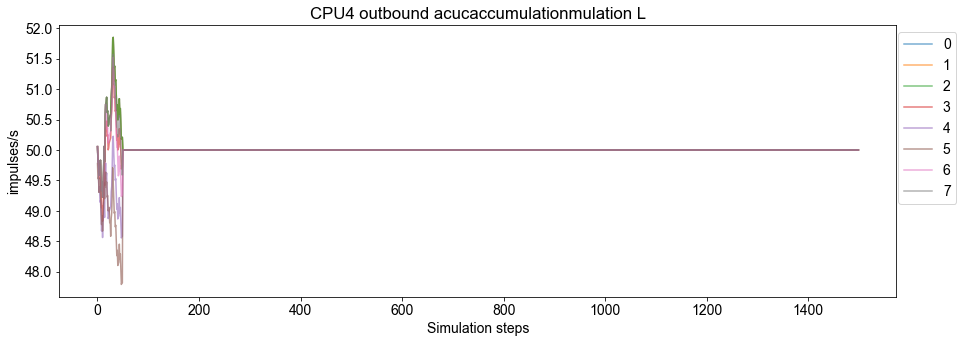

In [29]:
plt.figure(figsize=(15,5))
ranges = range(CPU4_memory_history.shape[1]//2)
for r in ranges:
    plt.plot(CPU4_memory_history[:T_outbound,r], alpha=0.6, label=r)#, label=names[idx])
plt.legend(bbox_to_anchor=(1.08, 1))
#plt.xlim([1400,1500])
plt.title('CPU4 outbound acucaccumulationmulation L')
plt.ylabel('impulses/s')
plt.xlabel('Simulation steps')
plt.show()



<AxesSubplot:xlabel='time (ms)', ylabel='neuron index'>

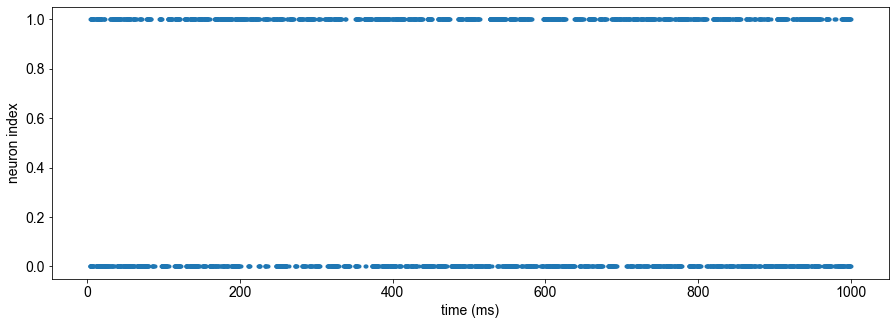

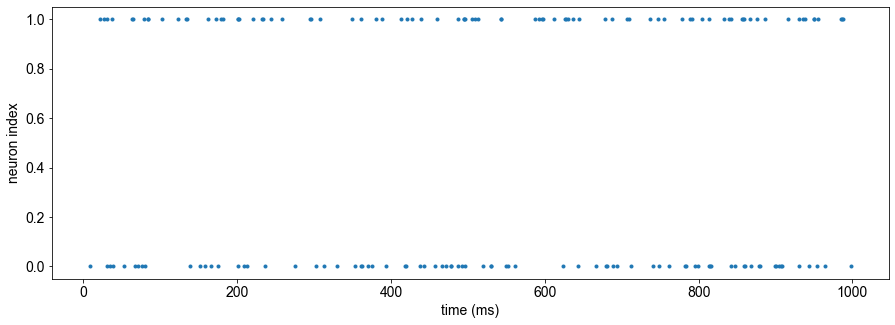

In [30]:
plt.figure(figsize=(15,5))
brian_plot(SPM_MOTOR)
plt.figure(figsize=(15,5))
brian_plot(SPM_MOTOR_TARGET)